<a href="https://colab.research.google.com/github/LikaOkudzhava/BrainyScan/blob/main/notebooks/Alzheimer_model_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

import os
import cv2

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from tqdm import tqdm

import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from imblearn.over_sampling import SMOTE

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import zipfile
from google.colab import drive

gdrive = '/content/drive'
drive.mount(gdrive, force_remount=False)

gdisk = os.path.join(gdrive, 'MyDrive')

filename = 'Copy of smallpreprocessed (1)'

archive_path = os.path.join(gdisk, filename)
with zipfile.ZipFile('/content/drive/MyDrive/Copy of smallpreprocessed (1).zip', 'r') as zip_ref:
 zip_ref.extractall(f'{filename}_extracted')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
preprocessing_function=tf.keras.applications.vgg19.preprocess_input


In [6]:
dataset_dir = '/content/Copy of smallpreprocessed (1)_extracted/data/SmallPreprocessed'
image_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    rescale=1./255,
    horizontal_flip=True
)
train_generator = datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

test_generator = datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

val_generator = datagen.flow_from_directory(
    os.path.join(dataset_dir, 'val'),
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

Found 4000 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


In [8]:
model = keras.models.Sequential()
model.add(
    tf.keras.applications.VGG19(
        input_shape = (image_size[0], image_size[1], 3),
        include_top = False,
        pooling = 'avg',
        weights = 'imagenet'))

model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(2048, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(4, activation='softmax'))
model.layers[0].trainable = False

# Build the model with the correct input shape
model.build(input_shape=(None, image_size[0], image_size[1], 3))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 512)            │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2048)           │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,191,620 (88.47 MB)

 Trainable params: 3,160,068 (12.05 MB)

 Non-trainable params: 20,031,552 (76.41 MB)

In [9]:
checkpoint_cb = ModelCheckpoint(
    "model_VGG19.keras",
    save_best_only = True)

early_stopping_cb = EarlyStopping(
    patience = 10,
    restore_best_weights = True
)

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'] # need to check it again
)

In [11]:
EPOCHS = 20

In [12]:
hist = model.fit(
    train_generator,
    epochs = EPOCHS,
    validation_data = val_generator,
    callbacks = [checkpoint_cb, early_stopping_cb]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 245ms/step - accuracy: 0.5495 - loss: 1.9242 - val_accuracy: 0.3300 - val_loss: 1.3328
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 232ms/step - accuracy: 0.7507 - loss: 0.6441 - val_accuracy: 0.3650 - val_loss: 1.2535
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 238ms/step - accuracy: 0.7965 - loss: 0.4989 - val_accuracy: 0.6100 - val_loss: 0.8977
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 239ms/step - accuracy: 0.8325 - loss: 0.4357 - val_accuracy: 0.7575 - val_loss: 0.5815
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 239ms/step - accuracy: 0.8493 - loss: 0.3913 - val_accuracy: 0.7850 - val_loss: 0.5459
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 246ms/step - accuracy: 0.8741 - loss: 0.3387 - val_accuracy: 0.8025 - val_loss: 0.5379
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 241ms/step - accuracy: 0.8738 - loss: 0.3289 - val_accuracy: 0.8263 - val_loss: 0.5164
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 238ms/step - accuracy: 0.9093 - loss: 0.2405 - val

In [ ]:
model.save('../models/template_model.keras')
model.export('../models/template_model')

In [13]:
score, acc= model.evaluate(test_generator)
print('Val Loss =', score)
print('Val Accuracy =', acc)

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step - accuracy: 0.8522 - loss: 0.4954
Val Loss = 0.5331056714057922
Val Accuracy = 0.8349999785423279


In [14]:
hist_=pd.DataFrame(hist.history)

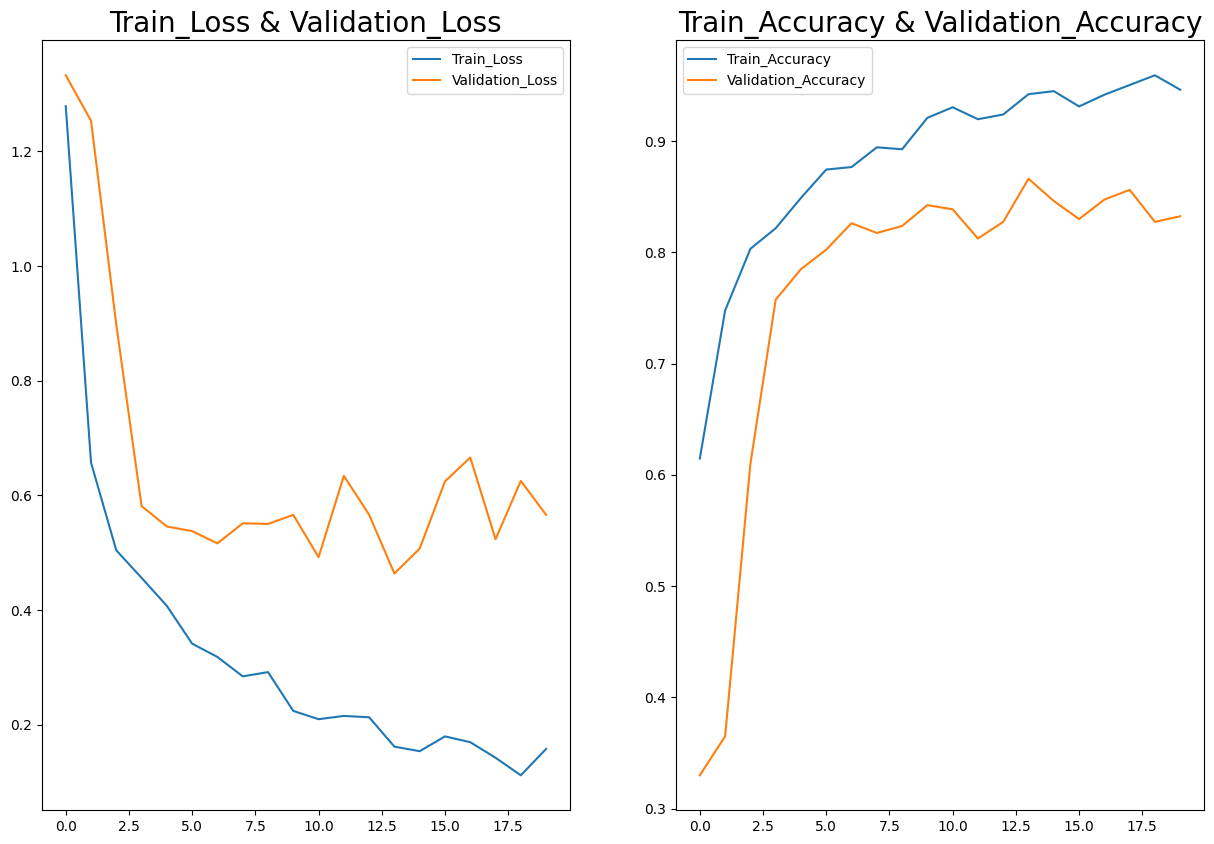

In [15]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [16]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})

25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step


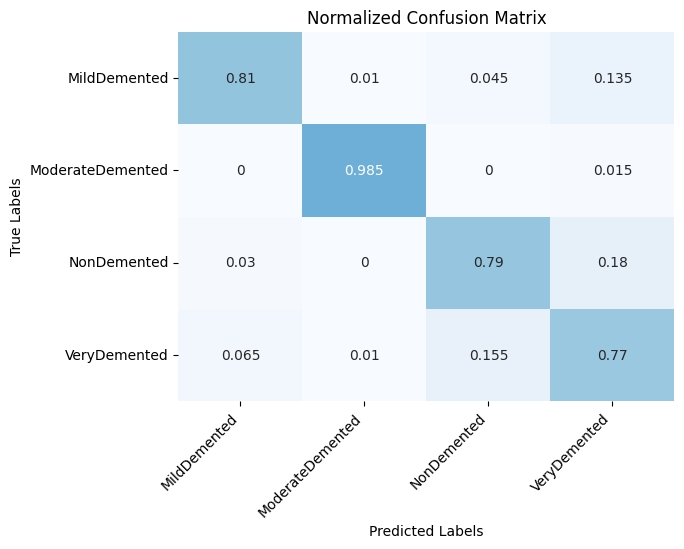

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


CM = confusion_matrix(y_test, y_pred)


CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
class_names = ['MildDemented','ModerateDemented', 'NonDemented', 'VeryDemented']

sns.heatmap(CM_percent, fmt='g', center=True, cbar=False, annot=True,
            cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()


In [18]:
from sklearn.metrics import classification_report
class_names = ['MildDemented','ModerateDemented', 'NonDemented', 'VeryDemented']
ClassificationReport = classification_report(y_test, y_pred, target_names=class_names)
print('Classification Report is:\n', ClassificationReport)


Classification Report is:
                   precision    recall  f1-score   support

    MildDemented       0.90      0.81      0.85       200
ModerateDemented       0.98      0.98      0.98       200
     NonDemented       0.80      0.79      0.79       200
    VeryDemented       0.70      0.77      0.73       200

        accuracy                           0.84       800
       macro avg       0.84      0.84      0.84       800
    weighted avg       0.84      0.84      0.84       800



/bin/bash: line 1: gitpush: command not found
